# Sintonización

##### Version 0.1

`Contenido Original creado por Ezequiel Leonardo Castaño`

<font color='Firebrick'>Este contenido está en <b>BORRADOR</b> y puede estar incompleto y/o sufrir modificaciones</font>

___

<nav style="display: flex; justify-content: space-evenly;">
    <a href="https://elc.github.io/control"><img src="https://img.shields.io/badge/Book-Chapters-blue?style=for-the-badge&amp;logo=GitBook&amp;logoColor=white"></a>
    <a href="https://github.com/ELC/control-theory-with-matlab"><img src="https://img.shields.io/badge/Github-Repo-green?style=for-the-badge&amp;logo=github&amp;logoColor=white"></a>
    <a href="https://github.com/ELC/control-theory-with-matlab/issues"><img src="https://img.shields.io/badge/Github%20Issues-Questions-orange?style=for-the-badge"></a>
</nav>

<br><nav style="display: flex; justify-content: space-between;">
    <a href="https://elc.github.io/link/control_06"><img src="https://img.shields.io/badge/%20%20%3C%20Previous%20Chapter--grey?style=for-the-badge"></a>
    <a href="https://elc.github.io/link/control_08"><img src="https://img.shields.io/badge/Next%20Chapter%20%3E--grey?style=for-the-badge"></a>
</nav>

In [ ]:
%plot inline --format=png -w 1600 -h 500

In [2]:
format compact;

# Sintonización

El proceso de sintonización consiste en modificar las ganancias de un controlador para lograr un comportamiento que se ajuste a los requerimientos de diseño. Existen varias técnicas para la sintonización, el proceso puede verse en la siguiente animación. [Fuente](https://en.wikipedia.org/wiki/PID_controller#Manual_tuning)

<center><img src="images/sintonization/image_00.png"></center>

# Sintonización por Curva de Reacción del Proceso (CPR)

Se remueve el controlador y se evalua la salida en lazo abierto ante una entrada escalón

Sólo se puede aplicar si la salida tiene forma de S

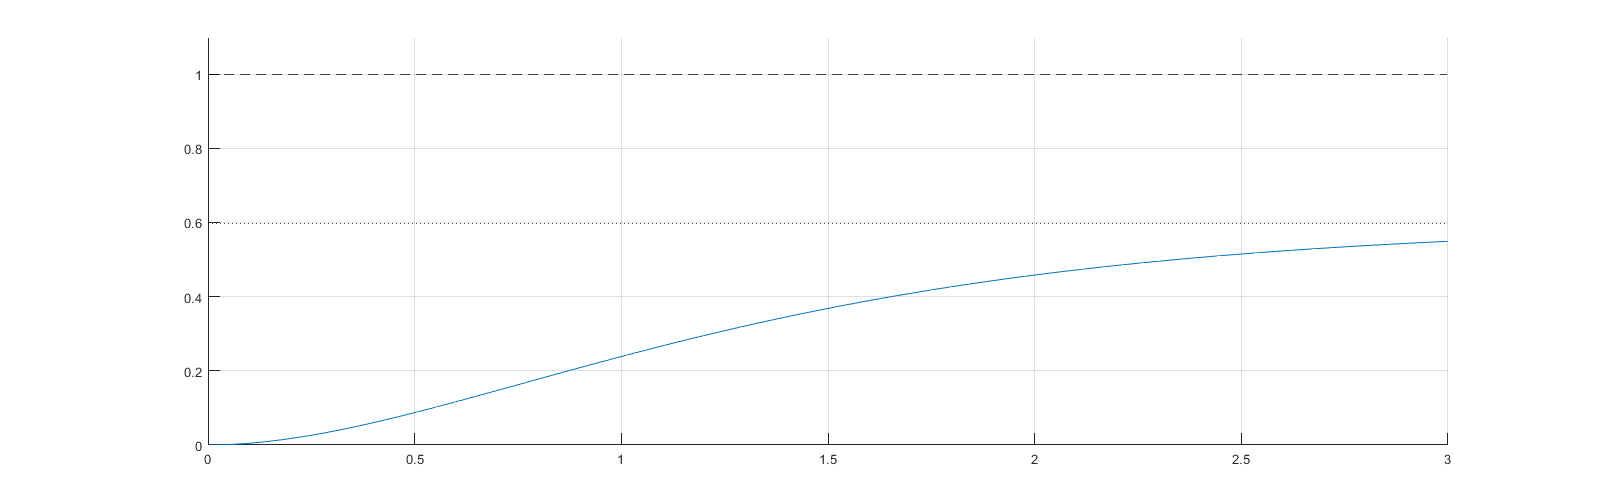

In [3]:
num = [1 3];
den = [1 5 9 5];
sistema = tf(num, den);
lazo_cerrado = feedback(sistema, 1);

[respuesta, tiempo] = step(sistema);
figure;
hold on;
plot(tiempo, respuesta)
yline(1, "--k")
yline(max(respuesta), ":k")
ylim([0 1.1])
xlim([0 3])
grid on

Se calcula en punto de inflexión numéricamente
<center><img src="images/sintonization/image_01.png"></center>

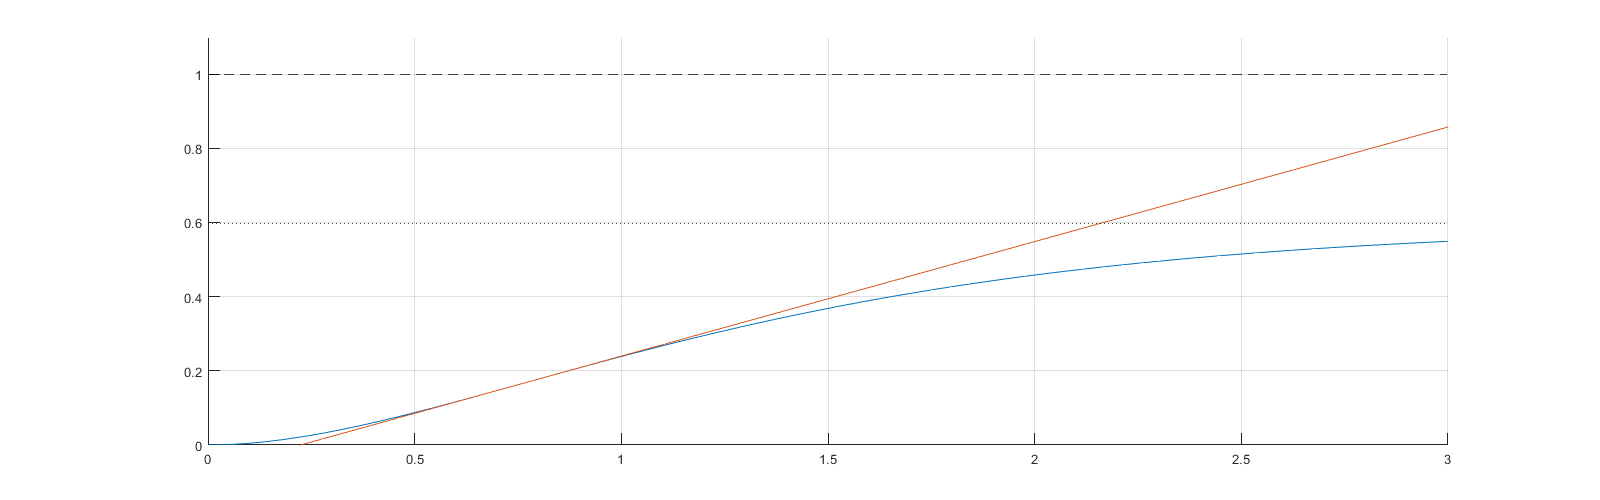

In [4]:
figure;
hold on
pendiente_en_tiempo = gradient(respuesta, tiempo);
[pendiente, indice_critico] = max(pendiente_en_tiempo);
tiempo_inflexion = tiempo(indice_critico);
respuesta_critica = respuesta(indice_critico);

recta_tangente = pendiente * (tiempo - tiempo_inflexion) + respuesta_critica;
plot(tiempo, respuesta)
plot(tiempo, recta_tangente)

xlim([0 3])

yline(max(respuesta), ":k")
yline(1, "--k")
ylim([0 1.1])
grid on

In [5]:
L = tiempo_inflexion - (respuesta_critica/pendiente)

L =
    0.2236



In [6]:
Tau = respuesta(end) / pendiente

Tau =
    1.9375



<center><img src="images/sintonization/image_02.png"></center>
<center><img src="images/sintonization/image_03.png"></center>

## Definiendo controlador Proporcional (P)

In [7]:
Kp = Tau / L;
controlador_p = tf([Kp], [1]);
lazo_cerrado_p = feedback(controlador_p*sistema, 1);

## Definiendo controlador Proporcional Integral (PI)

Forma estandar

In [8]:
Kp = 0.9 * Tau / L;
tau_i = L / 0.3;

Forma basada en ganacias

In [9]:
Ki = Kp / tau_i;
controlador_pi = tf([Kp Ki], [1 0]);
lazo_cerrado_pi = feedback(controlador_pi*sistema, 1);

## Definiendo controlador Proporcional Integral Derivativo (PID)

Usando la forma estandar

In [10]:
Kp = 1.2 * Tau / L;
tau_i = 2 * L;
tau_d = 0.5 * L;

Usando la forma de ganancia

In [11]:
Kp = Kp;
Ki = Kp / tau_i;
Kd = Kp * tau_d;

Definimos controlador PID

In [12]:
controlador_pid = tf([Kd Kp Ki], [1 0]);
lazo_cerrado_pid = feedback(controlador_pid*sistema, 1);

## Comparación de Controladores

### Comparación de Respuesta

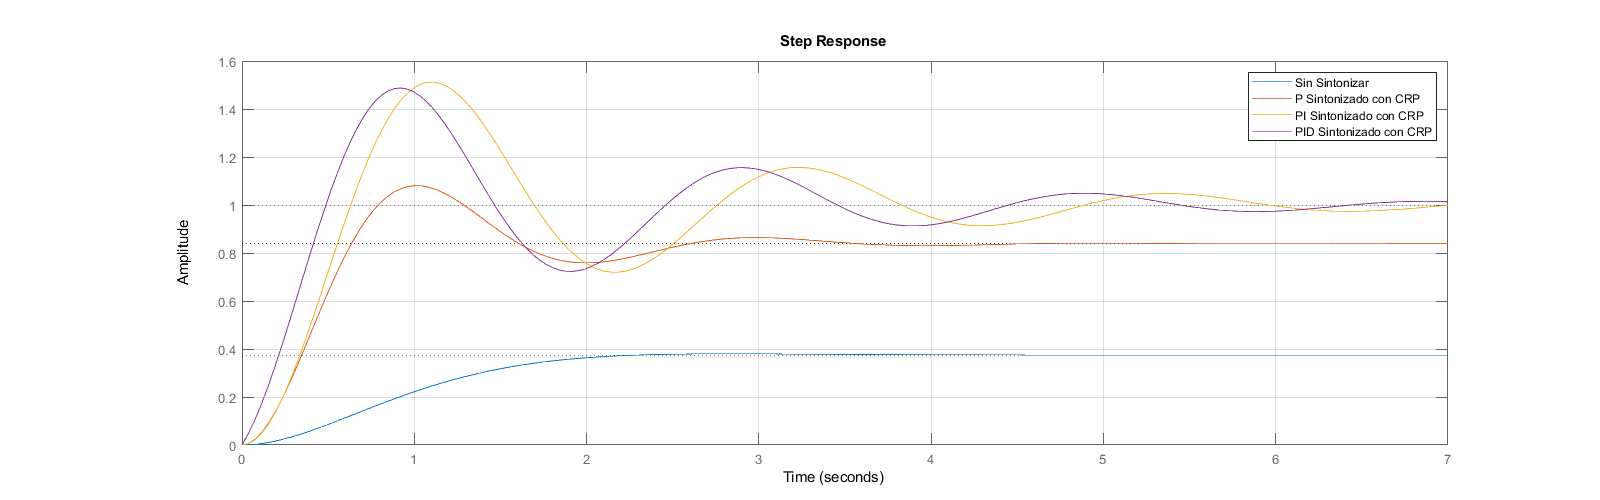

In [13]:
figure;
step(lazo_cerrado, lazo_cerrado_p, lazo_cerrado_pi, lazo_cerrado_pid)

xlim([0 7])

legend("Sin Sintonizar", "P Sintonizado con CRP", "PI Sintonizado con CRP", "PID Sintonizado con CRP")
grid on

### Comparación de ceros y polos

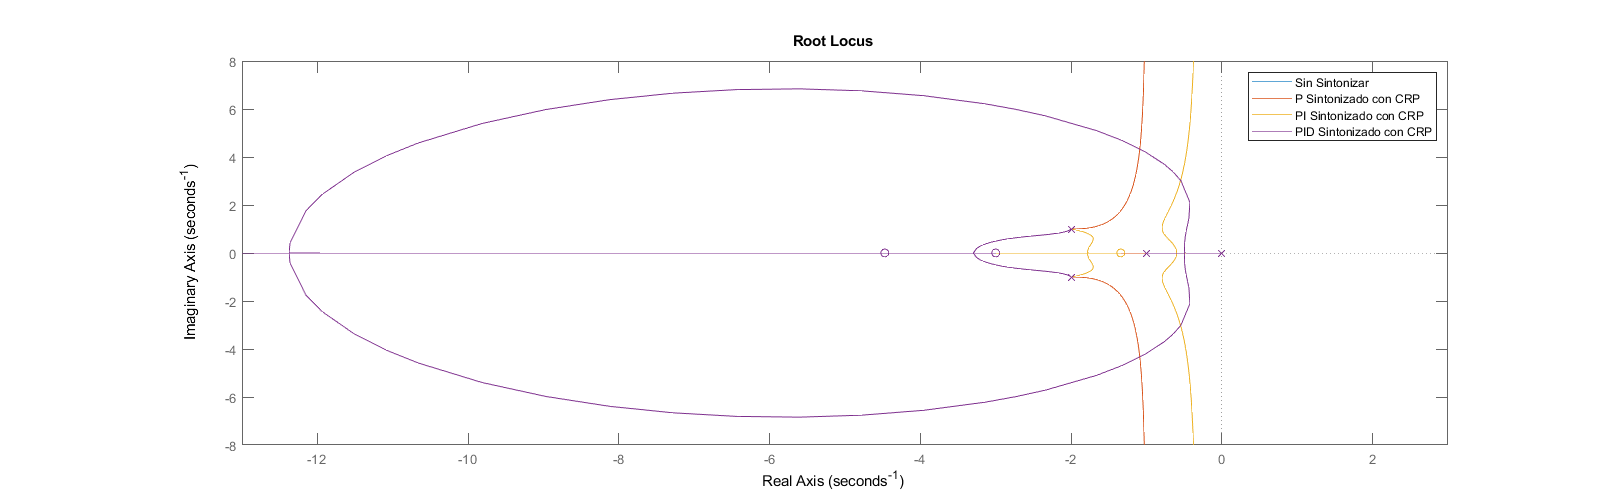

In [14]:
figure;
rlocus(sistema, controlador_p*sistema, controlador_pi*sistema, controlador_pid*sistema)
legend("Sin Sintonizar", "P Sintonizado con CRP", "PI Sintonizado con CRP", "PID Sintonizado con CRP")
xlim([-13 3])
ylim([-8 8])

# Sintonización por última ganancia o ganancia crítica (GC)

Es necesario que el lugar geométrico de las raices cruce al eje imaginario para poder aplicar este método

## Verificar Cruce con el eje imaginario

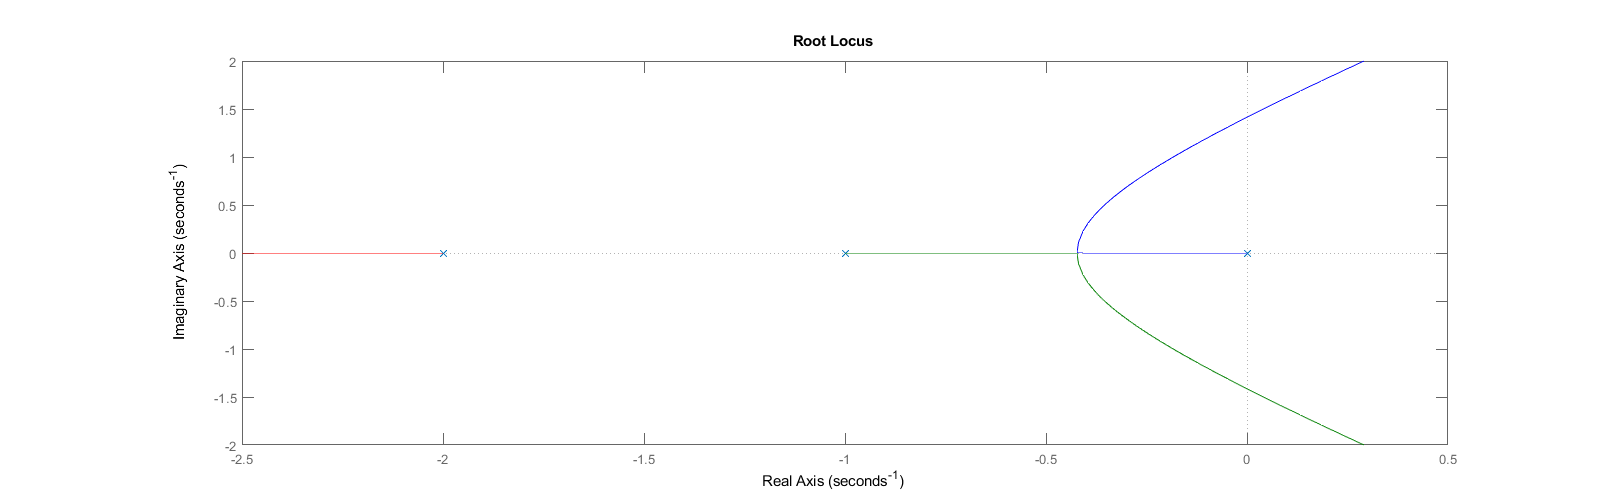

In [15]:
sistema = tf([1], [1 3 2 0]);
figure;
rlocus(sistema)
xlim([-2.5 0.5])
ylim([-2 2])

## Hallar valor de ganancia crítica $K$

Como las ramas cruzan el eje imaginario, se puede hallar el valor crítico de K. Este valor crítico se puede encontrar con Routh o utilizando el reemplazo de $s$ con $j\omega$

In [16]:
s = sym("s");
K = sym("k", "real");
w = sym("omega", "real");
sistema = K*(s+2) / (s^4 + 7*s^3 + 17.25*s^2 + 5.5*s - 30.75);
lazo_cerrado = sistema / (1 + sistema);

[num, ecuacion_caracteristica] = numden(lazo_cerrado);
remplazar_s = subs(ecuacion_caracteristica, s, j*w);
omega = solve(imag(remplazar_s) == 0, w)

> In sym/solve>warnIfParams (line 478)
  In sym/solve (line 357)
omega =
                        0
 -0.2673*(2*k + 11)^(1/2)
  0.2673*(2*k + 11)^(1/2)



In [17]:
K_critico = 6

K_critico =
     6



Se puede ver como el valor crítico de $K$ en este sistema es $6$

## Hallar el periodo crítico

El periodo crítico puede hallarse con la expresión $\frac{2\pi }{\omega }$

In [18]:
periodo_critico = 2 * pi / sqrt(2); % Obtenido de la variable omega

## Definiendo Controladores

In [19]:
sistema = tf([1], [1 3 2 0]);
lazo_cerrado = feedback(sistema, 1);

<center><img src="images/sintonization/image_04.png"></center>

## Definiendo controlador Proporcional (P)

In [20]:
Kp = 0.5 * K_critico;
controlador_p = tf([Kp], [1]);
lazo_cerrado_p = feedback(controlador_p*sistema, 1);

## Definiendo controlador Proporcional Integral (PI)

Forma estandar

In [21]:
Kp = 0.45 * K_critico;
tau_i = 1/1.2 * periodo_critico;

Forma basada en ganacias

In [22]:
Ki = Kp / tau_i;
controlador_pi = tf([Kp Ki], [1 0]);
lazo_cerrado_pi = feedback(controlador_pi*sistema, 1);

## Definiendo controlador Proporcional Integral Derivativo (PID)

Usando la forma estandar

In [23]:
Kp = 0.6 * K_critico;
tau_i = 0.5 * periodo_critico;
tau_d = 0.125 * periodo_critico;

Usando la forma de ganancia

In [24]:
Kp = Kp;
Ki = Kp / tau_i;
Kd = Kp * tau_d;

Definimos controlador PID

In [25]:
controlador_pid = tf([Kd Kp Ki], [1 0]);
lazo_cerrado_pid = feedback(controlador_pid*sistema, 1);

## Comparación de Controladores

### Comparación de Respuesta

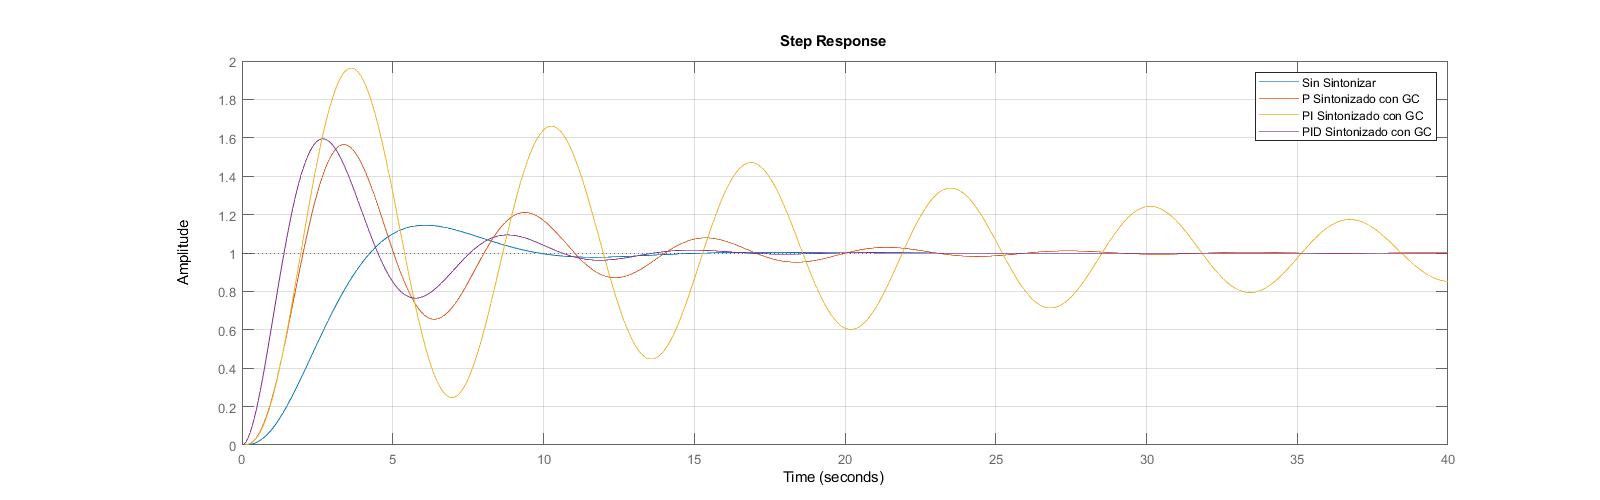

In [26]:
figure;
step(lazo_cerrado, lazo_cerrado_p, lazo_cerrado_pi, lazo_cerrado_pid)
legend("Sin Sintonizar", "P Sintonizado con GC", "PI Sintonizado con GC", "PID Sintonizado con GC")
xlim([0 40])
grid on

### Comparación de ceros y polos

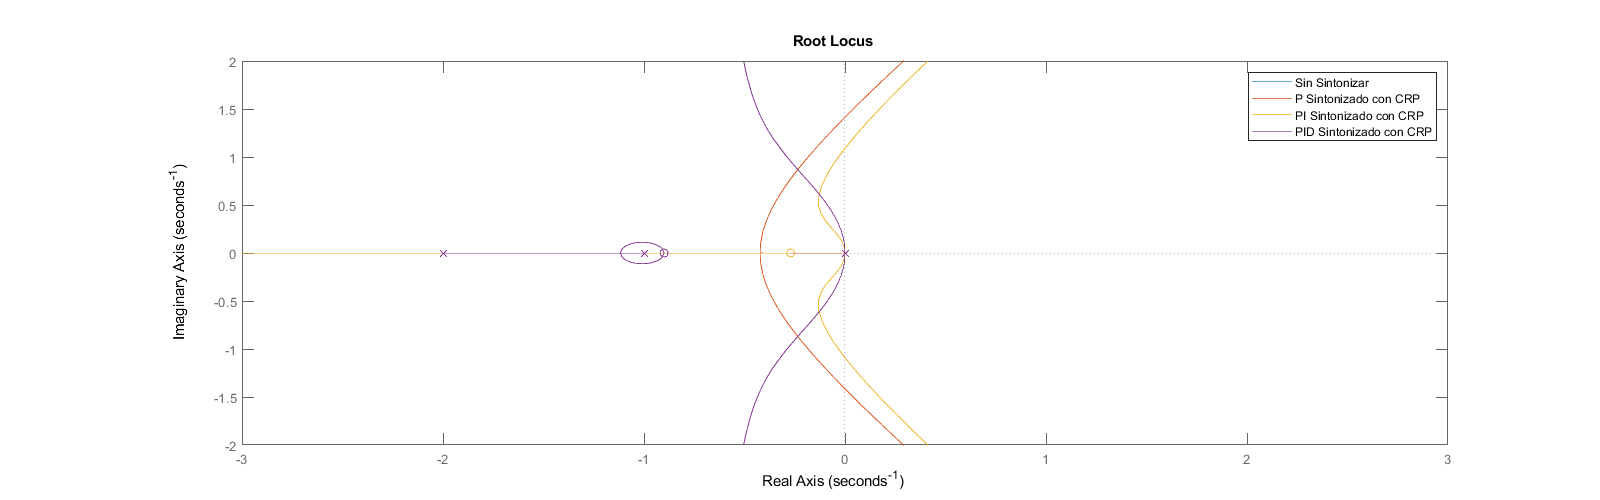

In [27]:
figure;
rlocus(sistema, controlador_p*sistema, controlador_pi*sistema, controlador_pid*sistema)
legend("Sin Sintonizar", "P Sintonizado con CRP", "PI Sintonizado con CRP", "PID Sintonizado con CRP")
xlim([-3 3])
ylim([-2 2])

# Sintonización por fuerza Bruta

Sintonizar el sistema para que cumpla con los siguientes requisitos **ante una entrada escalón**

- Tiempo de Asentamiento al 2\% a los 10s
- Error de estado estacionario nulo
- Overshoot de menos del 20\%

La función de transferencia de la planta es

$$G(s)=\frac{s^2 +2.1s+0.2}{s^5 +8.5s^4 +29.25s^3 +43.38s^2 +15.38s}$$

Tener en cuenta las siguientes consideraciones

- Se asume sensor ideal (retroalimentación unitaria)
- El valor máximo de la ganancia proporcional es de 5
- El valor máximo de la ganancia integral es de 5
- El valor máximo de la ganancia derivativa es de 2

## 1. Hallando Ganancia Proporcional $K_p$

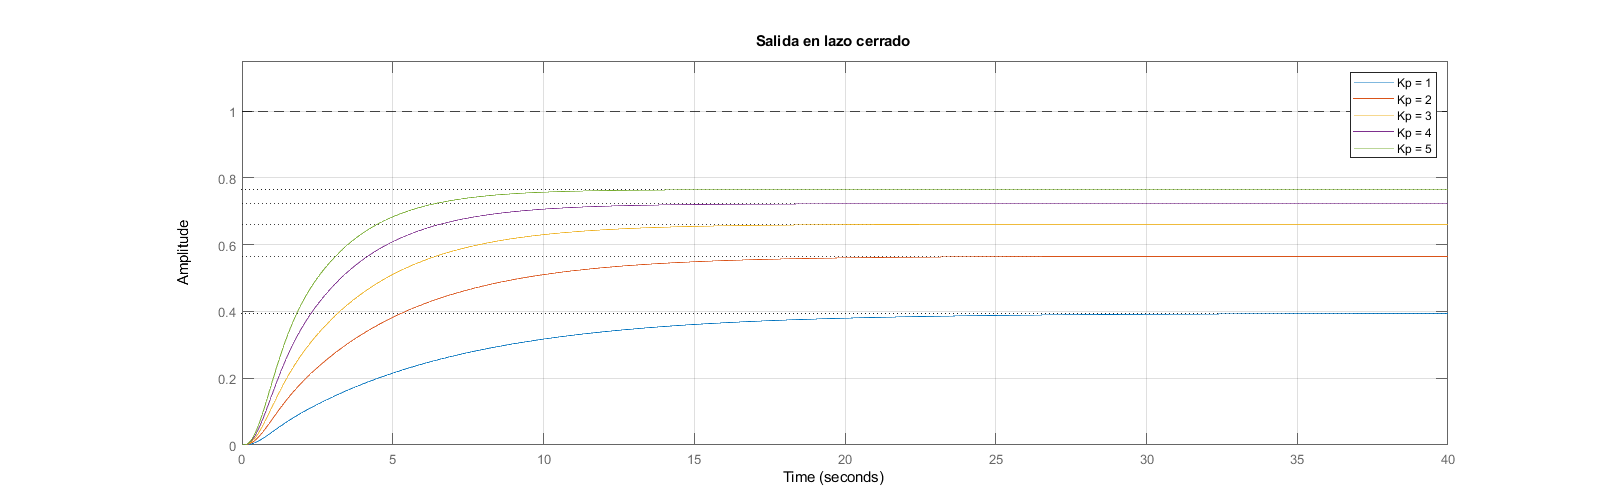

In [28]:
s = tf("s");

Kd = 0;
Ki = 0;
kps = [1 2 3 4 5];

ceros = transpose([-2]);
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);
sistema = tf(num, den);

for index = 1:length(kps)
    Kp = kps(index);
    controlador = Kp + Ki / s + Kd * s;
    lazo_cerrado_{index} = feedback(sistema*controlador, 1);
    legend_info{index} = ['Kp = ' num2str(Kp)]; 
end

figure;
hold on
step(lazo_cerrado_{:})
title("Salida en lazo cerrado")
xlim([0 40])
ylim([0 1.15])
yline(1, "--k")
legend(legend_info)
grid on

## 2. Hallando Ganancia Integral $K_i$

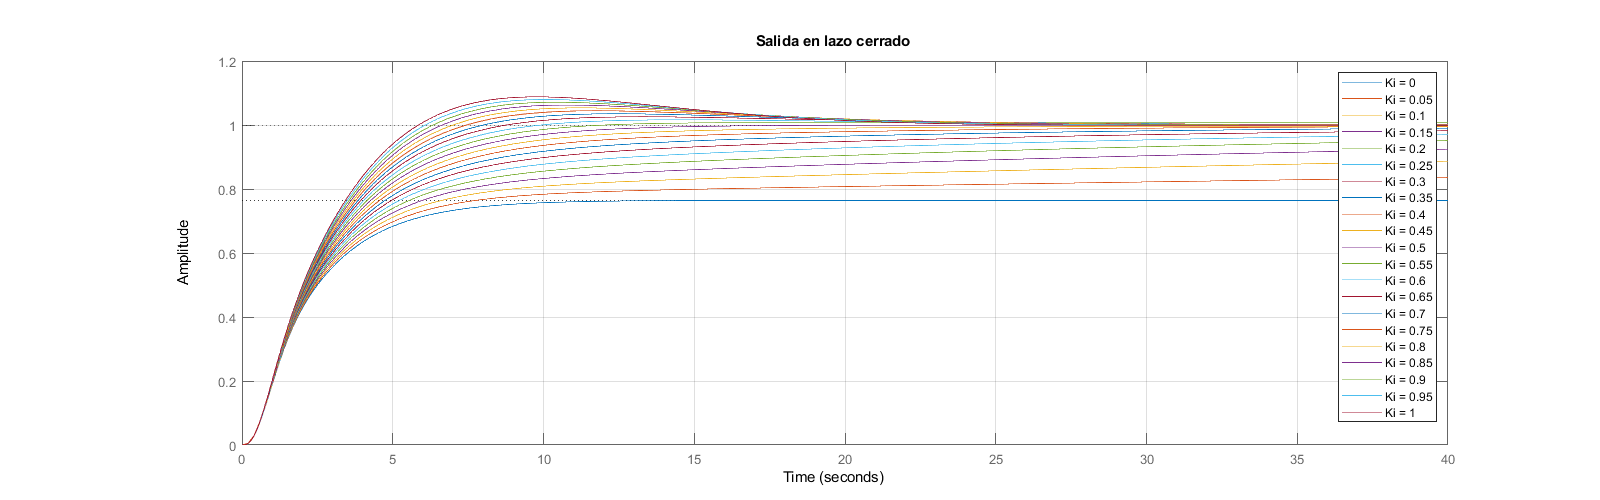

In [29]:
s = tf("s");

Kp = 5;
Kd = 0;
kis = 0:0.05:1;

ceros = transpose([-2]);
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);
sistema = tf(num, den);

for index = 1:length(kis)
    Ki = kis(index);
    controlador = Kp + Ki / s + Kd * s;
    lazo_cerrado_{index} = feedback(sistema*controlador, 1);
    legend_info{index} = ['Ki = ' num2str(Ki)]; 
end

figure;
hold on
step(lazo_cerrado_{:})
xlim([0 40])
title("Salida en lazo cerrado")
legend(legend_info)
grid on

## 3. Hallando Ganancia Derivativa $K_d$

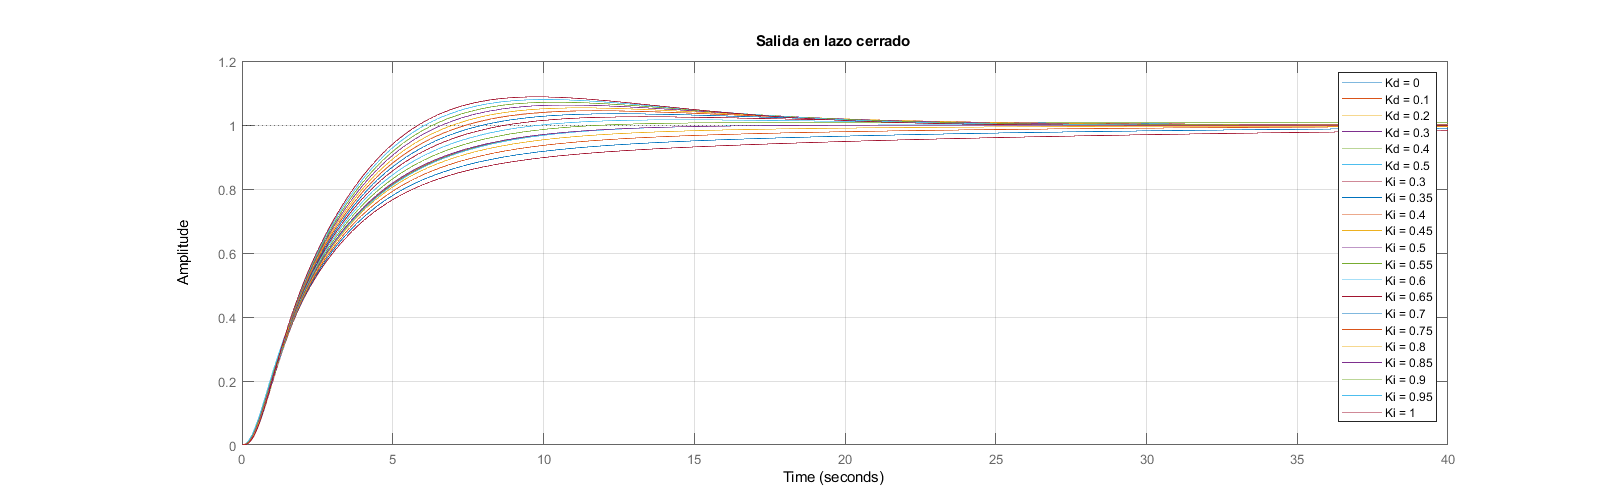

In [30]:
s = tf("s");

Kp = 5;
Ki = 0.5;
kds = 0:0.1:0.5;

ceros = transpose([-2]);
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);
sistema = tf(num, den);

for index = 1:length(kds)
    Kd = kds(index);
    controlador = Kp + Ki / s + Kd * s;
    lazo_cerrado_{index} = feedback(sistema*controlador, 1);
    legend_info{index} = ['Kd = ' num2str(Kd)]; 
end

figure;
hold on
step(lazo_cerrado_{:})
xlim([0 40])
title("Salida en lazo cerrado")
legend(legend_info)
grid on

## Sistema Sintonizado

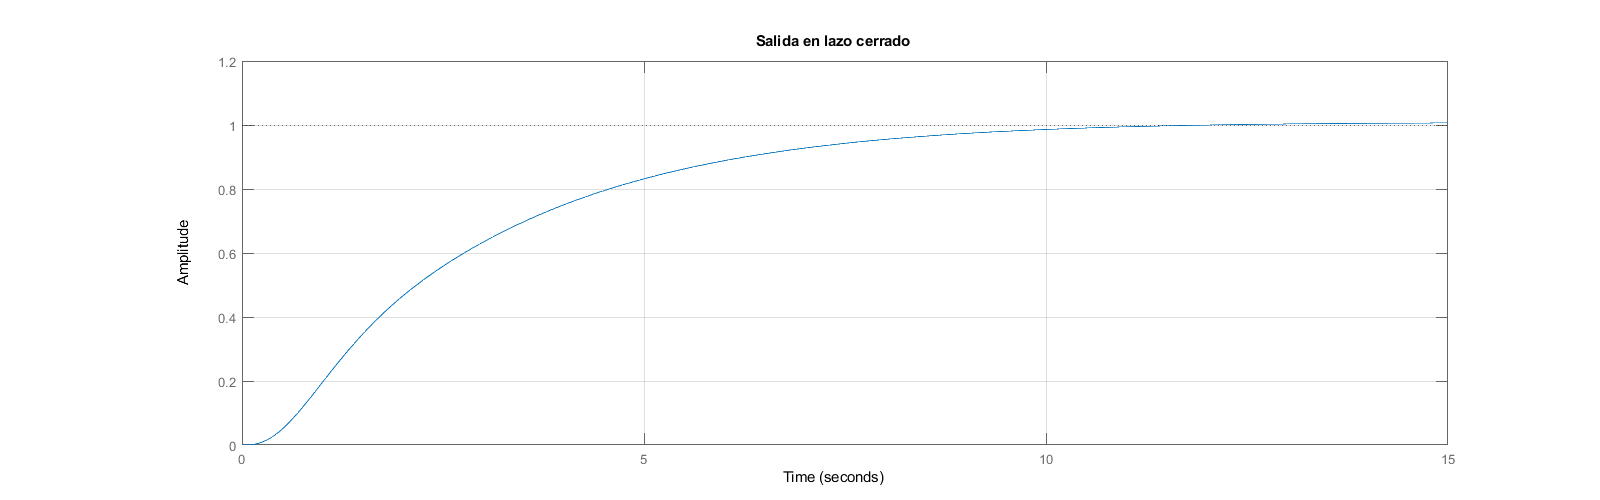

In [31]:
s = tf("s");

Kp = 5;
Ki = 0.55;
Kd = 0;

ceros = transpose([-2]);
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);
sistema = tf(num, den);

controlador = Kp + Ki / s + Kd * s;
lazo_cerrado = feedback(sistema*controlador, 1);

figure;
hold on
step(lazo_cerrado)
title("Salida en lazo cerrado")
grid on

# Sintonización Automática con Simulink

Para poder utilizar la sintonización automática con Simulink hace falta seguir los siguientes pasos:

## 1. Declarar las ganancias en el Workspace de Matlab

In [32]:
Kp = 1;
Ki = 1;
Kd = 1;

## 2. Construir un modelo en Simulink utilizando un controlador PID con los bloques básicos

Aclaraciónes importantes:

1. No utilizar el bloque PID que viene por defecto con Simulink porque no es compatible con la herramienta que se utilizará después
1. Los valores de las ganancias tienen que ser los mismos nombres de las variables definidos previamente en matlab
1. La función de transferencia tiene que definirse utilizando numerador y denominador. Si sólo se tienen los ceros y polos, usar la función **``zp2tf``** como se muestra acontinuación

In [33]:
ceros = [-2];
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);

<center><img src="images/sintonization/image_05.png"></center>

## 3. Agregar Verificación de Características

Conectar el bloque **Check Step Response Characteristics** que está dentro de **Simulink Design Optimization -> Model Verification** y agregarlo a la salida del sistema

<center><img src="images/sintonization/image_06.png"></center>
<center><img src="images/sintonization/image_07.png"></center>

## 4. Abrir el bloque y configurar los requisitos del sistema y presionar ``Apply``

<center><img src="images/sintonization/image_08.png"></center>

## 5. Presionar el botón **``Response Optimization``** y agregar nuevas variables de diseño

<center><img src="images/sintonization/image_09.png"></center>

**Seleccionar las tres ganancias en la lista de la derecha y pasarlas a la de la izquiera con el botón de la flecha y presionar ``OK``**

<center><img src="images/sintonization/image_10.png"></center>

**Asegurarse que los límites de las ganancias sean correctos, en este caso el enunciado especificaba límites máximos, pero las ganancias no deberían ser nunca negativas, así que el valor minimo debería ser 0.**

<center><img src="images/sintonization/image_11.png"></center>

## 6. Elegir el conjunto de variables de diseño y agregar el gráfico de evolución histórica

<center><img src="images/sintonization/image_12.png"></center>
<center><img src="images/sintonization/image_13.png"></center>

## 7. Ejecutar la simulación y validar que no se cumplen los requisitos de diseño

<center><img src="images/sintonization/image_14.png"></center>

**Los requisitos se cumplen si toda la gráfica azul está dentro de la zona blanca**

<center><img src="images/sintonization/image_15.png"></center>

## 8. Acomodar las ventanas de los gráficos y presionar **``Optimize``**

<center><img src="images/sintonization/image_16.png"></center>
<center><img src="images/sintonization/image_17.png"></center>

## 9. Esperar a que la optimización converga

<center><img src="images/sintonization/image_18.png"></center>

## 10. Guardar los valores obtenidos

Una vez finalizada la optimización los valores de las variables optimizadas se podrán ver en la sección de ``MATLAB Workspace``, las variables fueron automáticamente guardadas pero es recomendable agregar los valores en el código que estemos usando para tener un respaldo.

<center><img src="images/sintonization/image_19.png"></center>

## Sistema Sintonizado

En este caso puede comprobarse que los valores obtenidos automáticamente son muy similares a los hallados con el enfoque de fuerza bruta.

A diferencia de otros métodos, en este caso uno no necesita explicitar si el controlador a utilizar será P, PD, PI o PID. Si el coeficiente es nulo, ese componente de control no se utiliza.

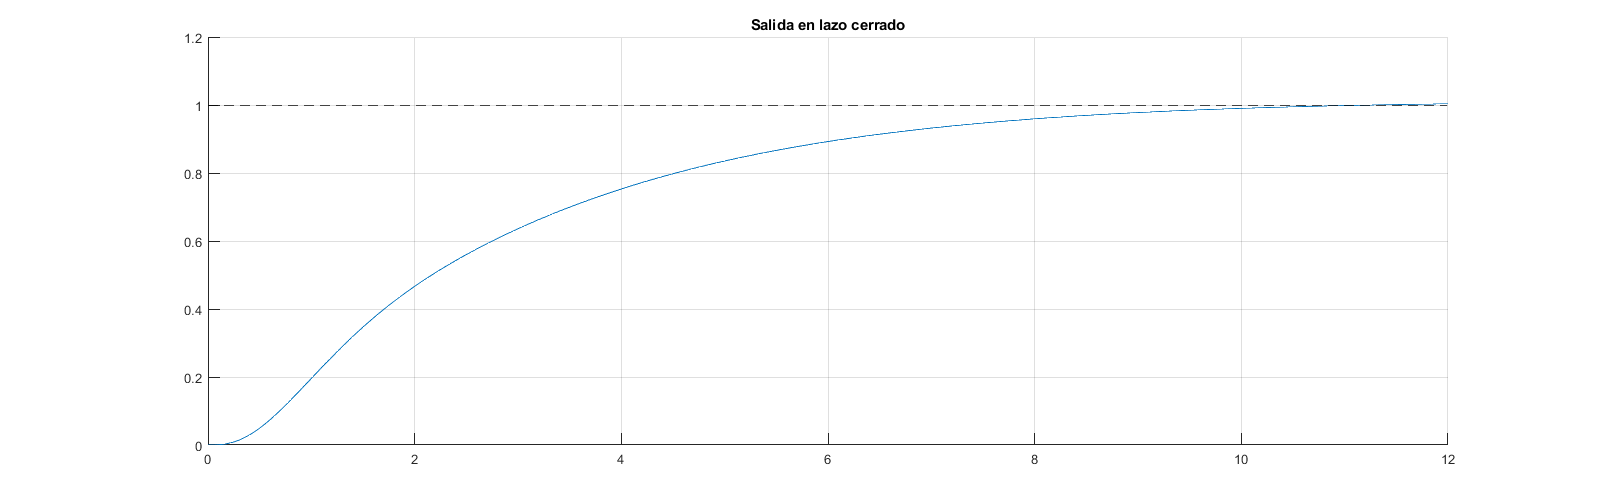

In [34]:
s = tf("s");

Kd = 0;
Ki = 0.5637;
Kp = 5;

ceros = transpose([-2]);
polos = [-3 -0.1 -2.5+2j -2.5-2j];
[num, den] = zp2tf(ceros, polos, [1]);
sistema = tf(num, den);

controlador = Kp + Ki / s + Kd * s;
lazo_cerrado = feedback(sistema*controlador, 1);

figure;
hold on
[respuesta, t] = step(lazo_cerrado);
plot(t, respuesta)
yline(1, "--k")
xlim([0 12])
title("Salida en lazo cerrado")
grid on

In [35]:
stepResults = stepinfo(respuesta, t)

stepResults = 
  struct with fields:

        RiseTime: 5.6476
    SettlingTime: 9.8380
     SettlingMin: 0.9089
     SettlingMax: 1.0086
       Overshoot: 0
      Undershoot: 0
            Peak: 1.0086
        PeakTime: 14.2181



<br><nav style="display: flex; justify-content: space-between;">
    <a href="https://elc.github.io/link/control_06"><img src="https://img.shields.io/badge/%20%20%3C%20Previous%20Chapter--grey?style=for-the-badge"></a>
    <a href="https://elc.github.io/link/control_08"><img src="https://img.shields.io/badge/Next%20Chapter%20%3E--grey?style=for-the-badge"></a>
</nav>